Data source: https://www.kaggle.com/sameersmahajan/seattle-house-sales-prices

In [0]:
# Import necessary modules

import pandas as pd
import matplotlib.pyplot as plt
import time
from pylab import rcParams
%config InlineBackend.figure_format='retina'

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

from keras import metrics
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import optimizers
from keras.wrappers.scikit_learn import KerasRegressor
# import talos as ta
# from talos.model import lr_normalizer, hidden_layers

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

Using TensorFlow backend.


In [0]:
# Load the data and parse date column

data = pd.read_csv('house_sales.csv', parse_dates=['date'])
del data['id']
data['date'] = data['date'].astype('str')
regex = '(?P<Year>[^-]+)-(?P<Month>[^-]+)-(?P<Day>[^-]+)'
data = pd.concat([data, data['date'].str.extract(regex).astype(int)], axis=1)
del data['date']
data.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,Year,Month,Day
0,221900,3,1.00,1180,5650,1.0,0,0,3,7,...,1955,0,98178,47.5112,-122.257,1340,5650,2014,10,13
1,538000,3,2.25,2570,7242,2.0,0,0,3,7,...,1951,1991,98125,47.7210,-122.319,1690,7639,2014,12,9
2,180000,2,1.00,770,10000,1.0,0,0,3,6,...,1933,0,98028,47.7379,-122.233,2720,8062,2015,2,25
3,604000,4,3.00,1960,5000,1.0,0,0,5,7,...,1965,0,98136,47.5208,-122.393,1360,5000,2014,12,9
4,510000,3,2.00,1680,8080,1.0,0,0,3,8,...,1987,0,98074,47.6168,-122.045,1800,7503,2015,2,18


In [0]:
# Scale features to to be between 0 and 1

data = pd.DataFrame(MinMaxScaler().fit_transform(data), columns=data.columns)
data.head()

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,Year,Month,Day
0,0.019266,0.090909,0.12500,0.067170,0.003108,0.0,0.0,0.0,0.5,0.500000,...,0.478261,0.000000,0.893939,0.571498,0.217608,0.161934,0.005742,0.0,0.818182,0.400000
1,0.060721,0.090909,0.28125,0.172075,0.004072,0.4,0.0,0.0,0.5,0.500000,...,0.443478,0.988089,0.626263,0.908959,0.166113,0.222165,0.008027,0.0,1.000000,0.266667
2,0.013770,0.060606,0.12500,0.036226,0.005743,0.0,0.0,0.0,0.5,0.416667,...,0.286957,0.000000,0.136364,0.936143,0.237542,0.399415,0.008513,1.0,0.090909,0.800000
3,0.069377,0.121212,0.37500,0.126038,0.002714,0.0,0.0,0.0,1.0,0.500000,...,0.565217,0.000000,0.681818,0.586939,0.104651,0.165376,0.004996,0.0,1.000000,0.266667
4,0.057049,0.090909,0.25000,0.104906,0.004579,0.0,0.0,0.0,0.5,0.583333,...,0.756522,0.000000,0.368687,0.741354,0.393688,0.241094,0.007871,1.0,0.090909,0.566667


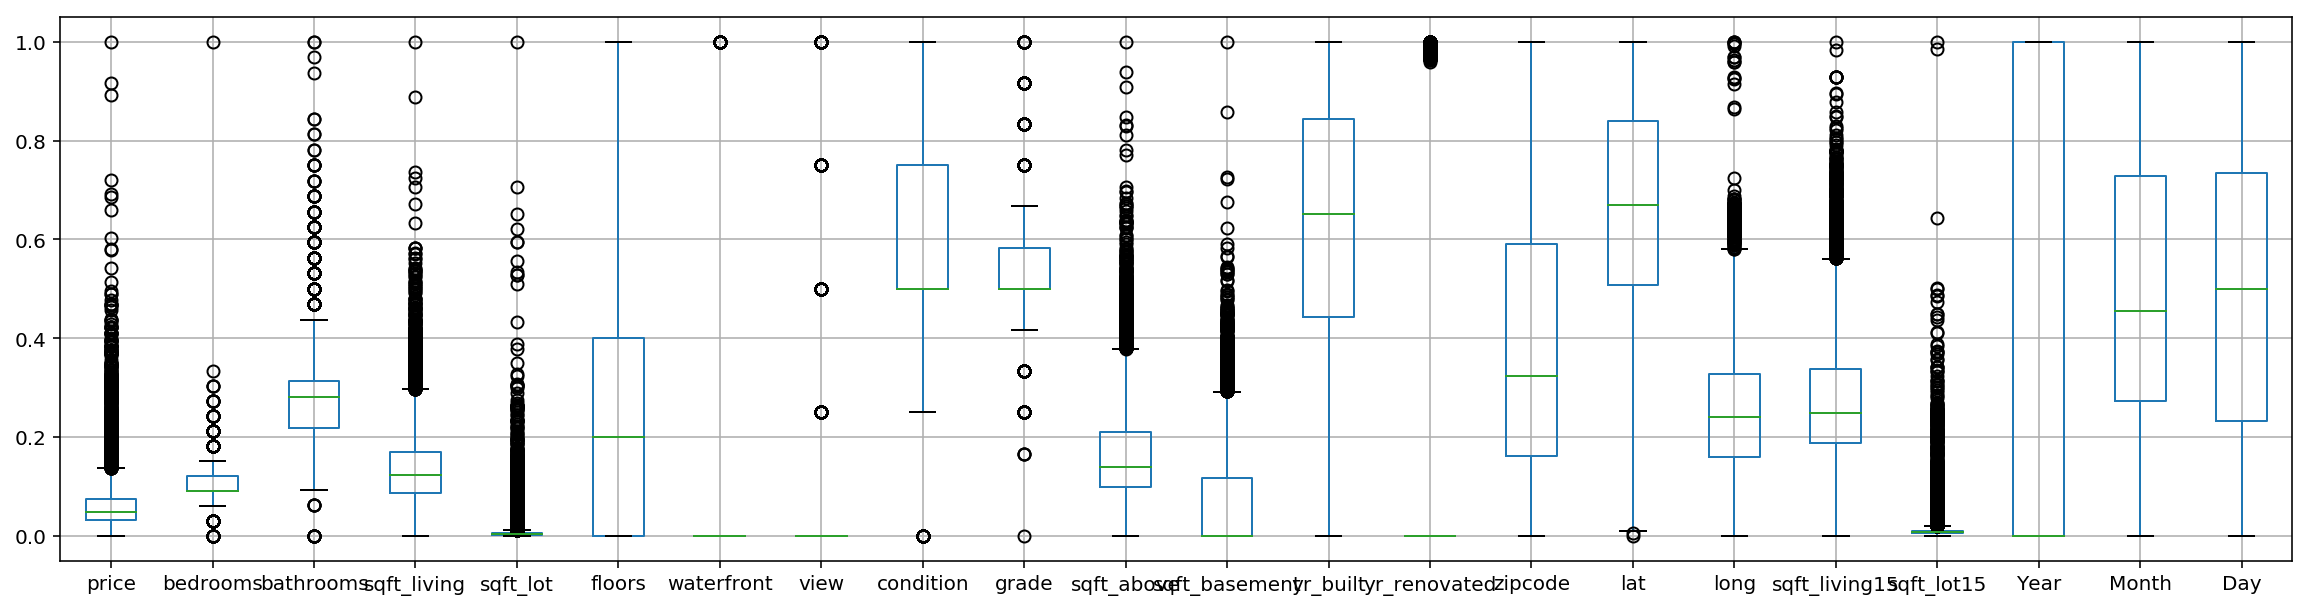

In [0]:
# Check the outliers

rcParams['figure.figsize'] = (20, 5)
boxplot = data.boxplot(column=list(data.columns))
plt.show()

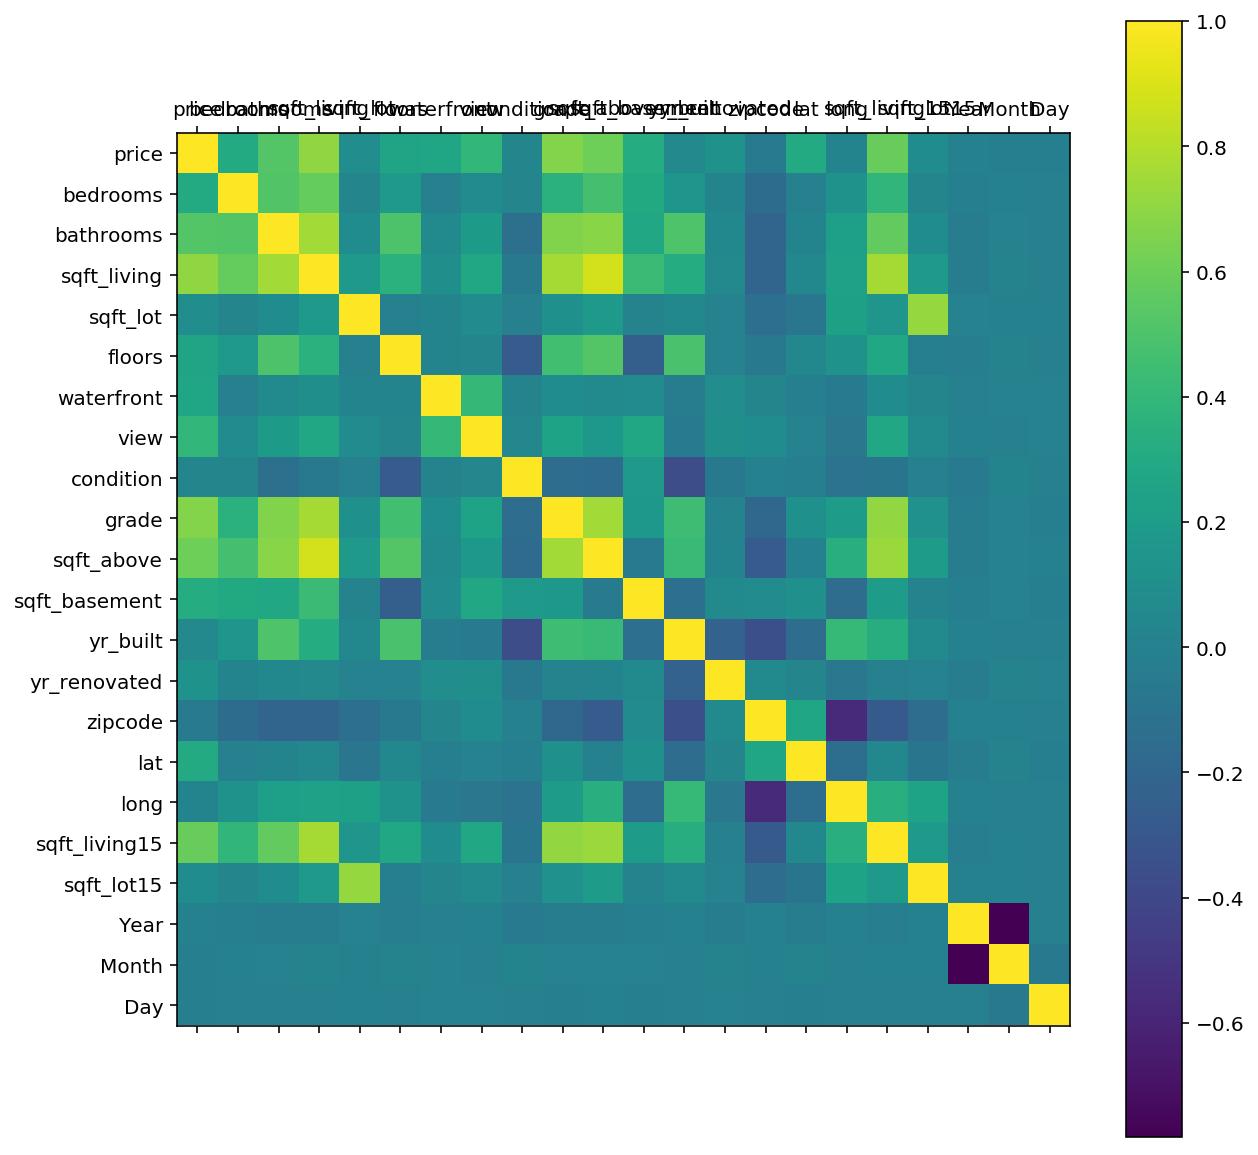

In [0]:
# Correlation heatmap

rcParams['figure.figsize'] = (10, 10)
corr = data.corr()
plt.matshow(corr)
plt.xticks(range(len(corr.columns)), corr.columns)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.colorbar()
plt.show()

In [0]:
data.corr()['price'].sort_values()

zipcode         -0.053203
Day             -0.014670
Month           -0.010081
Year             0.003576
long             0.021626
condition        0.036362
yr_built         0.054012
sqft_lot15       0.082447
sqft_lot         0.089661
yr_renovated     0.126434
floors           0.256794
waterfront       0.266369
lat              0.307003
bedrooms         0.308350
sqft_basement    0.323816
view             0.397293
bathrooms        0.525138
sqft_living15    0.585379
sqft_above       0.605567
grade            0.667434
sqft_living      0.702035
price            1.000000
Name: price, dtype: float64

In [0]:
# Split the data for training and testing

X = data.drop('price',axis=1)
y = data['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X_train.shape, X_test.shape

((16209, 21), (5404, 21))

In [0]:
# Find dimensionality of the output space

data['price'].nunique()

4032

In [0]:
# x = data.drop('price',axis=1).values
# y = data['price'].values

# # Model function required for the Scan
# def housing_model(x_train, y_train, x_val, y_val, params):

#     # Build the Keras model
#     model = Sequential()
#     model.add(Dense(30, input_dim=x_train.shape[1],
#                     activation=params['activation'],
#                     kernel_initializer='normal'))
#     model.add(Dropout(params['dropout']))   
#     model.add(Dense(1, activation=params['last_activation'],
#                     kernel_initializer='normal'))
#     model.compile(loss=params['losses'],
#                   # Add the regularizer normalization function from talos
#                   optimizer=params['optimizer'](lr=lr_normalizer(params['lr'],params['optimizer'])),
#                   metrics=['accuracy'])
    
#     history = model.fit(x_train, y_train, 
#                         validation_data=[x_val, y_val],
#                         batch_size=params['batch_size'],
#                         epochs=params['epochs'],
#                         verbose=0)
    
#     return history, model
  
# # Set the parameter space
# p = {'lr': (0.5, 1, 3),
#      'first_neuron':[30, 40, 50],
#      'hidden_layers':[0, 1, 2],
#      'batch_size': (2, 30, 10),
#      'epochs': [20],
#      'dropout': (0, 0.1, 0.5),
#      'weight_regulizer':[None],
#      'emb_output_dims': [None],
#      'optimizer': [Adam, Nadam],
#      'losses': [mean_squared_error],
#      'activation':[relu, selu],
#      'last_activation': [linear]}

# # Run the param scan
# t = ta.Scan(x=x,
#             y=y,
#             model=housing_model,
#             grid_downsample=0.01, 
#             params=p,
#             dataset_name='housing_seattle',
#             experiment_no='1')

In [0]:
model = Sequential()
model.add(Dense(50, input_dim=21, activation='relu'))
model.add(Dense(30, activation='relu'))
model.add(Dense(1, activation='linear'))

model.compile(optimizer='adam',loss='mean_squared_error',
              metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
%%time

model.fit(X_train, y_train, epochs=20, verbose=1, batch_size=10)

Instructions for updating:
Use tf.cast instead.
Epoch 1/20
16209/16209 [==============================] - 2s 108us/step - loss: 0.0016 - acc: 1.2339e-04
Epoch 2/20
16209/16209 [==============================] - 2s 97us/step - loss: 6.2929e-04 - acc: 1.2339e-04
Epoch 3/20
16209/16209 [==============================] - 2s 95us/step - loss: 5.5292e-04 - acc: 1.2339e-04
Epoch 4/20
16209/16209 [==============================] - 1s 85us/step - loss: 4.5995e-04 - acc: 1.2339e-04
Epoch 5/20
16209/16209 [==============================] - 1s 83us/step - loss: 4.3587e-04 - acc: 1.2339e-04
Epoch 6/20
16209/16209 [==============================] - 1s 83us/step - loss: 4.3096e-04 - acc: 1.2339e-04
Epoch 7/20
16209/16209 [==============================] - 1s 80us/step - loss: 3.9009e-04 - acc: 1.2339e-04
Epoch 8/20
16209/16209 [==============================] - 1s 81us/step - loss: 3.6642e-04 - acc: 1.2339e-04
Epoch 9/20
16209/16209 [==============================] - 1s 80us/step - loss: 3.5264e-04 -

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 50)                1100      
_________________________________________________________________
dense_2 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 31        
Total params: 2,661
Trainable params: 2,661
Non-trainable params: 0
_________________________________________________________________


In [0]:
y_predK = model.predict(X_test)
score = model.evaluate(X_test, y_test, verbose=0)
print('Keras Regression NN MSE:', score[0])

Keras Regression NN MSE: 0.000359325586035048


In [0]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_predL = linreg.predict(X_test)

mse = mean_squared_error(y_test, y_predL)
print('Linear Regression Model MSE:',mse)

Linear Regression Model MSE: 0.0007559808215279339


The loss of the Keras model is ~ 50% lower...

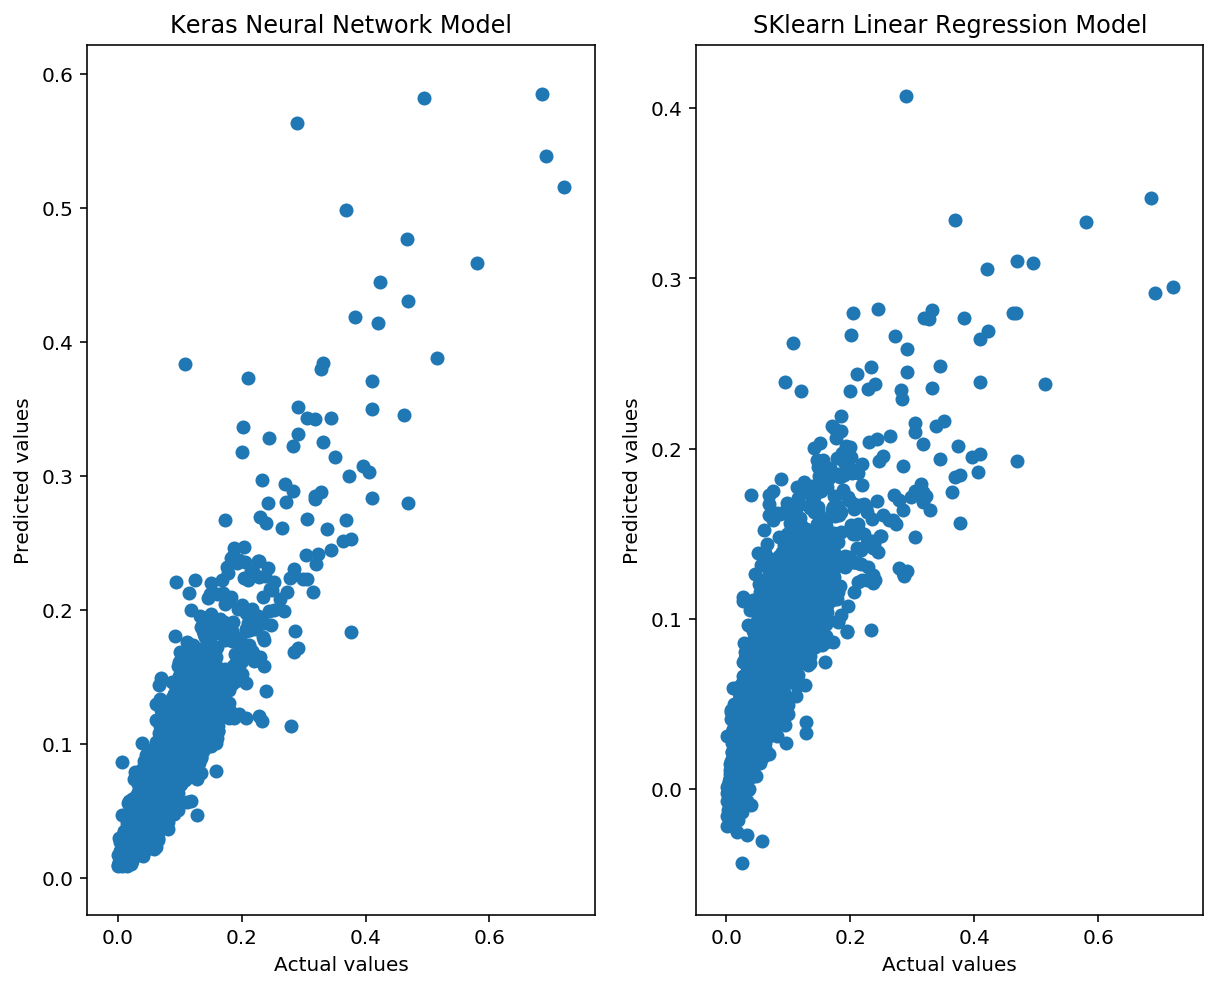

In [0]:
rcParams['figure.figsize'] = 10, 8
plt.figure(1)
plt.subplot(121)
plt.scatter(y_test, y_predK)
plt.xlabel("Actual values")
plt.ylabel("Predicted values")
plt.title("Keras Neural Network Model")

plt.subplot(122)
plt.scatter(y_test, y_predL)
plt.xlabel("Actual values")
plt.ylabel("Predicted values")
plt.title("SKlearn Linear Regression Model")
plt.show()